In [1]:
import re
import numpy as np
import collections
from sklearn import metrics
from sklearn.cross_validation import train_test_split
import tensorflow as tf
import pandas as pd
from unidecode import unidecode
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import time

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import malaya

In [3]:
tokenizer = malaya.preprocessing._SocialTokenizer().tokenize
rules_normalizer = malaya.texts._tatabahasa.rules_normalizer

def is_number_regex(s):
    if re.match("^\d+?\.\d+?$", s) is None:
        return s.isdigit()
    return True

def detect_money(word):
    if word[:2] == 'rm' and is_number_regex(word[2:]):
        return True
    else:
        return False

def preprocessing(string):
    tokenized = tokenizer(unidecode(string))
    tokenized = [malaya.stem.naive(w) for w in tokenized]
    tokenized = [w.lower() for w in tokenized if len(w) > 1]
    tokenized = [rules_normalizer.get(w, w) for w in tokenized]
    tokenized = ['<NUM>' if is_number_regex(w) else w for w in tokenized]
    tokenized = ['<MONEY>' if detect_money(w) else w for w in tokenized]
    return tokenized

In [4]:
def build_dataset(words, n_words):
    count = [['GO', 0], ['PAD', 1], ['EOS', 2], ['UNK', 3]]
    counter = collections.Counter(words).most_common(n_words)
    count.extend(counter)
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 3)
        if index == 0:
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

def str_idx(corpus, dic, maxlen, UNK = 3):
    X = np.zeros((len(corpus), maxlen))
    for i in range(len(corpus)):
        for no, k in enumerate(corpus[i][:maxlen][::-1]):
            X[i, -1 - no] = dic.get(k, UNK)
    return X

In [5]:
import json

with open('tokenization.json') as fopen:
    dataset = json.load(fopen)
texts = dataset['texts']
labels = dataset['labels']
del dataset

In [6]:
import itertools

concat = list(itertools.chain(*texts))
vocabulary_size = len(list(set(concat)))
data, count, dictionary, rev_dictionary = build_dataset(concat, vocabulary_size)
print('vocab from size: %d'%(vocabulary_size))
print('Most common words', count[4:10])
print('Sample data', data[:10], [rev_dictionary[i] for i in data[:10]])

vocab from size: 194731
Most common words [('saya', 177803), ('yang', 107888), ('aku', 91097), ('ini', 79339), ('suka', 65113), ('rasa', 64662)]
Sample data [273, 2033, 5, 4, 112, 3489, 5, 151, 140, 5] ['buah', 'parti', 'yang', 'saya', 'gi', 'natal', 'yang', 'akhir', 'malam', 'yang']


In [7]:
with open('emotion-dictionary.json','w') as fopen:
    fopen.write(json.dumps({'dictionary':dictionary,'reverse_dictionary':rev_dictionary}))

In [8]:
def position_encoding(inputs):
    T = tf.shape(inputs)[1]
    repr_dim = inputs.get_shape()[-1].value
    pos = tf.reshape(tf.range(0.0, tf.to_float(T), dtype=tf.float32), [-1, 1])
    i = np.arange(0, repr_dim, 2, np.float32)
    denom = np.reshape(np.power(10000.0, i / repr_dim), [1, -1])
    enc = tf.expand_dims(tf.concat([tf.sin(pos / denom), tf.cos(pos / denom)], 1), 0)
    return tf.tile(enc, [tf.shape(inputs)[0], 1, 1])

class Model:
    def __init__(
        self,
        size_layer,
        num_layers,
        dimension_output,
        learning_rate,
        dropout,
        dict_size,
    ):
        def cells(size, reuse = False):
            return tf.contrib.rnn.DropoutWrapper(
                tf.nn.rnn_cell.LSTMCell(
                    size,
                    initializer = tf.orthogonal_initializer(),
                    reuse = reuse,
                ),
                state_keep_prob = dropout,
                output_keep_prob = dropout,
            )

        self.X = tf.placeholder(tf.int32, [None, None])
        self.Y = tf.placeholder(tf.int32, [None])
        encoder_embeddings = tf.Variable(
            tf.random_uniform([dict_size, size_layer], -1, 1)
        )
        encoder_embedded = tf.nn.embedding_lookup(encoder_embeddings, self.X)
        encoder_embedded += position_encoding(encoder_embedded)
        attention_mechanism = tf.contrib.seq2seq.BahdanauAttention(
            num_units = size_layer, memory = encoder_embedded
        )
        rnn_cells = tf.contrib.seq2seq.AttentionWrapper(
            cell = tf.nn.rnn_cell.MultiRNNCell(
                [cells(size_layer) for _ in range(num_layers)]
            ),
            attention_mechanism = attention_mechanism,
            attention_layer_size = size_layer,
            alignment_history = True,
        )
        outputs, last_state = tf.nn.dynamic_rnn(
            rnn_cells, encoder_embedded, dtype = tf.float32
        )
        self.alignments = tf.transpose(
            last_state.alignment_history.stack(), [1, 2, 0]
        )
        self.logits_seq = tf.layers.dense(outputs, dimension_output)
        self.logits_seq = tf.identity(self.logits_seq, name = 'logits_seq')
        self.logits = self.logits_seq[:, -1]
        self.logits = tf.identity(self.logits, name = 'logits')
        self.cost = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits = self.logits, labels = self.Y
            )
        )
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate = learning_rate
        ).minimize(self.cost)
        correct_pred = tf.equal(
            tf.argmax(self.logits, 1, output_type = tf.int32), self.Y
        )
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        self.attention = tf.nn.softmax(
            tf.reduce_sum(self.alignments[0], 1), name = 'alphas'
        )

In [9]:
size_layer = 256
num_layers = 2
dimension_output = 6
learning_rate = 1e-4
batch_size = 32
dropout = 0.8
maxlen = 50

tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model(
    size_layer,
    num_layers,
    dimension_output,
    learning_rate,
    dropout,
    len(dictionary),
)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(tf.trainable_variables())
saver.save(sess, 'bahdanau/model.ckpt')

'bahdanau/model.ckpt'

In [10]:
strings = ','.join(
    [
        n.name
        for n in tf.get_default_graph().as_graph_def().node
        if ('Variable' in n.op
        or 'Placeholder' in n.name
        or 'logits' in n.name
        or 'alphas' in n.name)
        and 'Adam' not in n.name
        and 'beta' not in n.name
    ]
)

In [11]:
strings.split(',')

['Placeholder',
 'Placeholder_1',
 'Variable',
 'memory_layer/kernel',
 'rnn/attention_wrapper/multi_rnn_cell/cell_0/lstm_cell/kernel',
 'rnn/attention_wrapper/multi_rnn_cell/cell_0/lstm_cell/bias',
 'rnn/attention_wrapper/multi_rnn_cell/cell_1/lstm_cell/kernel',
 'rnn/attention_wrapper/multi_rnn_cell/cell_1/lstm_cell/bias',
 'rnn/attention_wrapper/bahdanau_attention/query_layer/kernel',
 'rnn/attention_wrapper/bahdanau_attention/attention_v',
 'rnn/attention_wrapper/attention_layer/kernel',
 'dense/kernel',
 'dense/bias',
 'logits_seq',
 'logits',
 'alphas']

In [12]:
tf.trainable_variables()

[<tf.Variable 'Variable:0' shape=(194735, 256) dtype=float32_ref>,
 <tf.Variable 'memory_layer/kernel:0' shape=(256, 256) dtype=float32_ref>,
 <tf.Variable 'rnn/attention_wrapper/multi_rnn_cell/cell_0/lstm_cell/kernel:0' shape=(768, 1024) dtype=float32_ref>,
 <tf.Variable 'rnn/attention_wrapper/multi_rnn_cell/cell_0/lstm_cell/bias:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'rnn/attention_wrapper/multi_rnn_cell/cell_1/lstm_cell/kernel:0' shape=(512, 1024) dtype=float32_ref>,
 <tf.Variable 'rnn/attention_wrapper/multi_rnn_cell/cell_1/lstm_cell/bias:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'rnn/attention_wrapper/bahdanau_attention/query_layer/kernel:0' shape=(256, 256) dtype=float32_ref>,
 <tf.Variable 'rnn/attention_wrapper/bahdanau_attention/attention_v:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'rnn/attention_wrapper/attention_layer/kernel:0' shape=(512, 256) dtype=float32_ref>,
 <tf.Variable 'dense/kernel:0' shape=(256, 6) dtype=float32_ref>,
 <tf.Variable 'de

In [13]:
train_X, test_X, train_Y, test_Y = train_test_split(
    texts, labels, test_size = 0.2
)

In [14]:
from tqdm import tqdm
import time

EARLY_STOPPING, CURRENT_CHECKPOINT, CURRENT_ACC, EPOCH = 3, 0, 0, 0

while True:
    lasttime = time.time()
    if CURRENT_CHECKPOINT == EARLY_STOPPING:
        print('break epoch:%d\n' % (EPOCH))
        break

    train_acc, train_loss, test_acc, test_loss = 0, 0, 0, 0
    pbar = tqdm(
        range(0, len(train_X), batch_size), desc = 'train minibatch loop'
    )
    for i in pbar:
        batch_x = str_idx(train_X[i : min(i + batch_size, len(train_X))], dictionary, maxlen)
        batch_y = train_Y[i : min(i + batch_size, len(train_X))]
        batch_x_expand = np.expand_dims(batch_x,axis = 1)
        acc, cost, _ = sess.run(
            [model.accuracy, model.cost, model.optimizer],
            feed_dict = {
                model.Y: batch_y,
                model.X: batch_x
            },
        )
        assert not np.isnan(cost)
        train_loss += cost
        train_acc += acc
        pbar.set_postfix(cost = cost, accuracy = acc)

    pbar = tqdm(range(0, len(test_X), batch_size), desc = 'test minibatch loop')
    for i in pbar:
        batch_x = str_idx(test_X[i : min(i + batch_size, len(test_X))], dictionary, maxlen)
        batch_y = test_Y[i : min(i + batch_size, len(test_X))]
        batch_x_expand = np.expand_dims(batch_x,axis = 1)
        acc, cost = sess.run(
            [model.accuracy, model.cost],
            feed_dict = {
                model.Y: batch_y,
                model.X: batch_x
            },
        )
        test_loss += cost
        test_acc += acc
        pbar.set_postfix(cost = cost, accuracy = acc)

    train_loss /= len(train_X) / batch_size
    train_acc /= len(train_X) / batch_size
    test_loss /= len(test_X) / batch_size
    test_acc /= len(test_X) / batch_size

    if test_acc > CURRENT_ACC:
        print(
            'epoch: %d, pass acc: %f, current acc: %f'
            % (EPOCH, CURRENT_ACC, test_acc)
        )
        CURRENT_ACC = test_acc
        CURRENT_CHECKPOINT = 0
    else:
        CURRENT_CHECKPOINT += 1
        
    print('time taken:', time.time() - lasttime)
    print(
        'epoch: %d, training loss: %f, training acc: %f, valid loss: %f, valid acc: %f\n'
        % (EPOCH, train_loss, train_acc, test_loss, test_acc)
    )
    EPOCH += 1

train minibatch loop:   0%|          | 1/10513 [00:00<28:00,  6.25it/s, accuracy=0.812, cost=0.294]

epoch: 0, pass acc: 0.000000, current acc: 0.833860
time taken: 1806.4379632472992
epoch: 0, training loss: 0.507723, training acc: 0.778103, valid loss: 0.358880, valid acc: 0.833860



train minibatch loop:   0%|          | 1/10513 [00:00<29:09,  6.01it/s, accuracy=0.812, cost=0.282]

epoch: 1, pass acc: 0.833860, current acc: 0.851374
time taken: 1805.9654252529144
epoch: 1, training loss: 0.323606, training acc: 0.846076, valid loss: 0.306598, valid acc: 0.851374



train minibatch loop:   0%|          | 1/10513 [00:00<28:33,  6.14it/s, accuracy=0.844, cost=0.245]

epoch: 2, pass acc: 0.851374, current acc: 0.855572
time taken: 1804.1147470474243
epoch: 2, training loss: 0.286857, training acc: 0.857566, valid loss: 0.290092, valid acc: 0.855572



train minibatch loop:   0%|          | 1/10513 [00:00<28:32,  6.14it/s, accuracy=0.812, cost=0.258]

epoch: 3, pass acc: 0.855572, current acc: 0.856321
time taken: 1802.9133727550507
epoch: 3, training loss: 0.268571, training acc: 0.862905, valid loss: 0.282082, valid acc: 0.856321



train minibatch loop:   0%|          | 1/10513 [00:00<28:00,  6.26it/s, accuracy=0.812, cost=0.24]

epoch: 4, pass acc: 0.856321, current acc: 0.858425
time taken: 1803.940958738327
epoch: 4, training loss: 0.256094, training acc: 0.866911, valid loss: 0.276821, valid acc: 0.858425



train minibatch loop:   0%|          | 1/10513 [00:00<27:52,  6.29it/s, accuracy=0.812, cost=0.243]

time taken: 1803.388067483902
epoch: 5, training loss: 0.245726, training acc: 0.870467, valid loss: 0.277493, valid acc: 0.857688



train minibatch loop:   0%|          | 1/10513 [00:00<29:00,  6.04it/s, accuracy=0.812, cost=0.261]

time taken: 1804.126121044159
epoch: 6, training loss: 0.237529, training acc: 0.873686, valid loss: 0.276567, valid acc: 0.855631



test minibatch loop: 100%|██████████| 2629/2629 [01:39<00:00, 26.42it/s, accuracy=1, cost=0.136]     

time taken: 1804.089854478836
epoch: 7, training loss: 0.230081, training acc: 0.876284, valid loss: 0.281058, valid acc: 0.855274

break epoch:8



In [15]:
saver.save(sess, 'bahdanau/model.ckpt')

'bahdanau/model.ckpt'

In [27]:
text = preprocessing('kerajaan sebenarnya sangat bencikan rakyatnya, minyak naik dan segalanya')
new_vector = str_idx([text], dictionary, len(text))
sess.run(tf.nn.softmax(model.logits), feed_dict={model.X:new_vector})

array([[9.5579243e-01, 1.7140401e-03, 5.8068730e-05, 8.2103559e-04,
        3.7833266e-02, 3.7811873e-03]], dtype=float32)

In [28]:
sess.run(tf.nn.softmax(model.logits_seq), feed_dict={model.X:new_vector})

array([[[8.7503439e-01, 4.0796096e-03, 1.1681291e-02, 1.9761901e-02,
         6.7219168e-02, 2.2223648e-02],
        [9.0185910e-01, 3.2690407e-03, 4.4285068e-03, 5.0989017e-03,
         6.5191031e-02, 2.0153401e-02],
        [8.9758867e-01, 3.0799001e-03, 1.5591373e-03, 1.3781149e-03,
         7.1173072e-02, 2.5221055e-02],
        [9.5248526e-01, 2.3611211e-03, 1.0431354e-04, 2.4577207e-04,
         3.9272953e-02, 5.5305962e-03],
        [9.6152484e-01, 1.7582704e-03, 1.2012023e-04, 6.5628305e-04,
         3.3400975e-02, 2.5393744e-03],
        [9.7122645e-01, 1.2968729e-03, 8.8663553e-05, 3.0159278e-04,
         2.5308592e-02, 1.7777863e-03],
        [9.7071302e-01, 1.3172423e-03, 3.1681499e-05, 4.9125007e-04,
         2.5583209e-02, 1.8636443e-03],
        [9.4375247e-01, 2.9528595e-03, 7.0040813e-05, 7.4037589e-04,
         4.7362212e-02, 5.1220795e-03]]], dtype=float32)

In [18]:
real_Y, predict_Y = [], []

pbar = tqdm(
    range(0, len(test_X), batch_size), desc = 'validation minibatch loop'
)
for i in pbar:
    batch_x = str_idx(test_X[i : min(i + batch_size, len(test_X))], dictionary, maxlen)
    batch_y = test_Y[i : min(i + batch_size, len(test_X))]
    predict_Y += np.argmax(
        sess.run(
            model.logits, feed_dict = {model.X: batch_x, model.Y: batch_y}
        ),
        1,
    ).tolist()
    real_Y += batch_y

validation minibatch loop: 100%|██████████| 2629/2629 [01:36<00:00, 27.19it/s]


In [19]:
print(
    metrics.classification_report(
        real_Y, predict_Y, target_names = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']
    )
)

             precision    recall  f1-score   support

      anger       0.91      0.92      0.92     14943
       fear       0.87      0.86      0.87      7630
        joy       0.94      0.89      0.92     16570
       love       0.94      0.92      0.93     15729
    sadness       0.73      0.91      0.81     19849
   surprise       0.77      0.47      0.58      9383

avg / total       0.86      0.86      0.85     84104



In [29]:
def freeze_graph(model_dir, output_node_names):

    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            'directory: %s' % model_dir
        )

    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path

    absolute_model_dir = '/'.join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + '/frozen_model.pb'
    clear_devices = True
    with tf.Session(graph = tf.Graph()) as sess:
        saver = tf.train.import_meta_graph(
            input_checkpoint + '.meta', clear_devices = clear_devices
        )
        saver.restore(sess, input_checkpoint)
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess,
            tf.get_default_graph().as_graph_def(),
            output_node_names.split(','),
        )
        with tf.gfile.GFile(output_graph, 'wb') as f:
            f.write(output_graph_def.SerializeToString())
        print('%d ops in the final graph.' % len(output_graph_def.node))

In [30]:
freeze_graph('bahdanau', strings)

INFO:tensorflow:Restoring parameters from bahdanau/model.ckpt
INFO:tensorflow:Froze 11 variables.
INFO:tensorflow:Converted 11 variables to const ops.
467 ops in the final graph.


In [31]:
def load_graph(frozen_graph_filename):
    with tf.gfile.GFile(frozen_graph_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def)
    return graph

In [32]:
g = load_graph('bahdanau/frozen_model.pb')
x = g.get_tensor_by_name('import/Placeholder:0')
logits_seq = g.get_tensor_by_name('import/logits_seq:0')
logits = g.get_tensor_by_name('import/logits:0')
alphas = g.get_tensor_by_name('import/alphas:0')
test_sess = tf.InteractiveSession(graph = g)
result = test_sess.run([logits, alphas, logits_seq], feed_dict = {x: new_vector})

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [34]:
news_string = 'Kerajaan juga perlu prihatin dan peka terhadap nasib para nelayan yang bergantung rezeki sepenuhnya kepada sumber hasil laut. Malah, projek ini memberikan kesan buruk yang berpanjangan kepada alam sekitar selain menjejaskan mata pencarian para nelayan'

In [35]:
text = preprocessing(news_string)
new_vector = str_idx([text], dictionary, len(text))
result = test_sess.run([tf.nn.softmax(logits), alphas, tf.nn.softmax(logits_seq)], feed_dict = {x: new_vector})

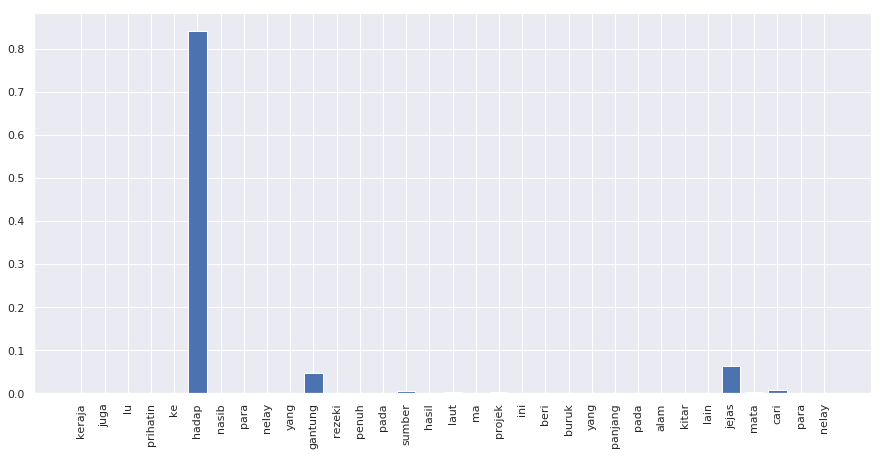

In [37]:
plt.figure(figsize = (15, 7))
labels = [word for word in text]
val = [val for val in result[1]]
plt.bar(np.arange(len(labels)), val)
plt.xticks(np.arange(len(labels)), labels, rotation = 'vertical')
plt.show()

In [38]:
result[2]

array([[[2.35456795e-01, 1.13787755e-01, 1.84029154e-02, 1.97571106e-02,
         3.58908951e-01, 2.53686517e-01],
        [2.87183911e-01, 1.10419728e-01, 6.76609343e-03, 7.39877205e-03,
         3.95097911e-01, 1.93133548e-01],
        [2.93474674e-01, 9.24961194e-02, 3.47279944e-03, 4.31073969e-03,
         3.56325060e-01, 2.49920636e-01],
        [2.56820053e-01, 5.62430136e-02, 1.60429871e-03, 1.89781131e-03,
         4.57970738e-01, 2.25464091e-01],
        [2.02544361e-01, 4.08357903e-02, 9.25916014e-04, 1.67246012e-03,
         4.72074866e-01, 2.81946659e-01],
        [2.34901190e-01, 3.72201838e-02, 9.34051641e-04, 3.78618250e-03,
         4.67558861e-01, 2.55599588e-01],
        [2.30352208e-01, 3.63332182e-02, 5.74249076e-04, 4.50069457e-03,
         5.30165315e-01, 1.98074311e-01],
        [3.16199005e-01, 5.38086556e-02, 7.98433903e-04, 3.22504505e-03,
         4.72374409e-01, 1.53594494e-01],
        [3.72093201e-01, 8.07847381e-02, 1.16029277e-03, 8.58110841e-03,
       